In [ ]:
## Create Augmented data for specific classes

In [ ]:
import os
import numpy as np
import random
from tqdm import tqdm
import shutil

DATA_ROOT = "../../fiot_highway2-main/data/"
TRAIN_TXT = "../../fiot_highway2-main/train.txt"

# boost class 3 with 50 addtional items with small freq and time drop out
# 4 = 20
# 5 = 20
# 7 = 15
# 8 = 15
# 6 = 5
TARGET_LABEL = 1
OUTPUT_COUNT = 100
OUTPUT_FOLDER = f'./BoostedClass{TARGET_LABEL}' 

SPEC_HEIGHT = 512
SPEC_WIDTH  = 243
MIN_DB = -140
MAX_DB = 0

shutil.rmtree(OUTPUT_FOLDER, ignore_errors=True)
os.makedirs(OUTPUT_FOLDER)

label_files = []

with open(TRAIN_TXT, "r") as f:
    for line in f:
        name, lbl = line.strip().split()
        name = os.path.basename(name)
        if int(lbl) == TARGET_LABEL:
            label_files.append(name)

if len(label_files) == 0:
    raise ValueError("No files found for label")

print(f"Found {len(label_files)} original label samples.")


Found 2247 original label samples.


In [ ]:
def augment_spectrogram1(spec):
    """
    Create a new spectrogram with small random perturbations.
    """

    # 1. Gaussian noise (small)
    noise = np.random.normal(0, 1.5, spec.shape)

    # 2. Random amplitude scaling
    scale = random.uniform(0.9, 1.1)

    # 3. Combine
    new_spec = spec * scale + noise

    # 4. Clip to valid dB range
    new_spec = np.clip(new_spec, MIN_DB, MAX_DB)

    return new_spec.astype(np.float32)

def augment_spectrogram2(spec):
    """
    Create a new spectrogram by blocking out a random chunk of pixels.
    """

    new_spec = np.copy(spec)

    # --- Random block size ---
    block_h = random.randint(40, 100)   # height between 10–80 pixels
    block_w = random.randint(40, 100)   # width between 10–80 pixels

    # --- Random position (top-left corner) ---
    top = random.randint(0, SPEC_HEIGHT - block_h)
    left = random.randint(0, SPEC_WIDTH - block_w)

    # --- Block-out the area ---
    # Option A: set to minimum dB (recommended for spectrograms)
    new_spec[top:top+block_h, left:left+block_w] = MIN_DB

    # Alternative Option B: set to zero
    # new_spec[top:top+block_h, left:left+block_w] = 0

    return new_spec.astype(np.float32)


def augment_spectrogram3(spec, time_mask_max=10, freq_mask_max=5, num_time_masks=1, num_freq_masks=1, add_noise=False, scale_amplitude=False):
    """
    Apply SpecAugment-style masking to a spectrogram.
    - time masking  = mask vertical chunks  (mask along time axis)
    - freq masking  = mask horizontal chunks (mask along frequency axis)
    """

    new_spec = np.copy(spec)

    H, W = new_spec.shape  # (freq_bins, time_frames)

    # 1. FREQUENCY MASKING
    for _ in range(num_freq_masks):
        mask_size = random.randint(4, freq_mask_max)
        f0 = random.randint(0, max(0, H - mask_size))
        new_spec[f0:f0 + mask_size, :] = MIN_DB

    # 2. TIME MASKING
    for _ in range(num_time_masks):
        mask_size = random.randint(2, time_mask_max)
        t0 = random.randint(0, max(0, W - mask_size))
        new_spec[:, t0:t0 + mask_size] = MIN_DB

    # 3. Gaussian noise
    if add_noise:
        noise = np.random.normal(0, 1.5, new_spec.shape)
        new_spec += noise

    # 4. amplitude scaling
    if scale_amplitude:
        scale = random.uniform(0.9, 1.1)
        new_spec *= scale

    # 5. Clip
    new_spec = np.clip(new_spec, MIN_DB, MAX_DB)

    return new_spec.astype(np.float32)


In [ ]:
print("Generating new spectrograms...")
counter = 0

for i in tqdm(range(OUTPUT_COUNT)):
    # Pick a random original label file
    base_file = random.choice(label_files)
    full_path = os.path.join(DATA_ROOT, base_file)

    spec = np.load(full_path)

    # Validate shape
    if spec.shape != (SPEC_HEIGHT, SPEC_WIDTH):
        raise ValueError(f"Unexpected shape in {base_file}: {spec.shape}")

    # Augment
    new_spec = augment_spectrogram1(spec)

    # Save generated sample
    out_name = f"gen_{i:05d}.npy"
    out_path = os.path.join(OUTPUT_FOLDER, out_name)
    np.save(out_path, new_spec)

print(f"Done Generated {OUTPUT_COUNT} new spectrograms in {OUTPUT_FOLDER}/")

Generating new spectrograms...


100%|██████████| 100/100 [00:00<00:00, 131.46it/s]

Done Generated 100 new spectrograms in ./BoostedClass1/


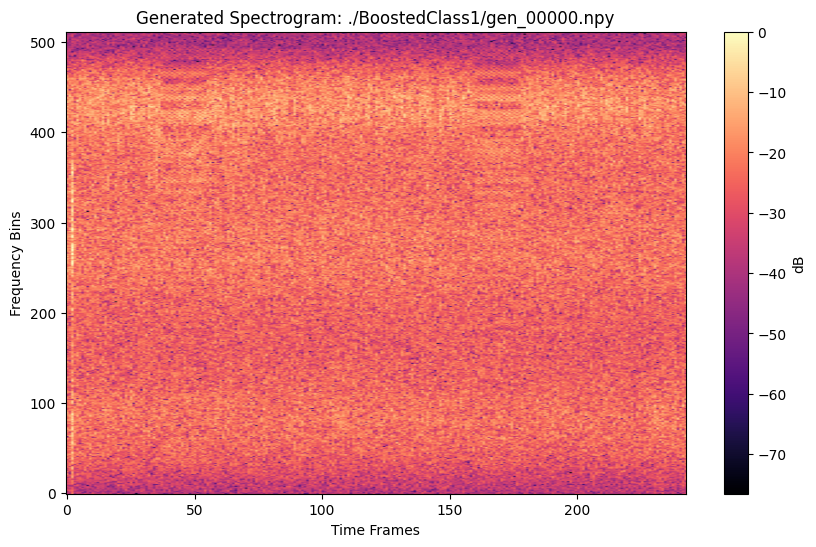

In [12]:
import matplotlib.pyplot as plt

# Pick one generated spectrogram to visualize
example_file = os.path.join(OUTPUT_FOLDER, "gen_00000.npy")
spec = np.load(example_file)

plt.figure(figsize=(10, 6))
plt.imshow(spec, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label="dB")
plt.title(f"Generated Spectrogram: {example_file}")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.show()